# Exploratory Data Analysis

In [2]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
import shap
import lime
import lime.lime_tabular

#load latest version of DataFrame as csv and extracts date information seperately from date column
df = pd.read_csv("./data/whole_data.csv", index_col=0)
df['Tarih'] = pd.to_datetime(df['Tarih'])
df["Ay"] = df["Tarih"].dt.month
df["Gun"] = df["Tarih"].dt.day
df["Year"] = df["Tarih"].dt.year
df = df.drop(columns=['Tarih','GUN'])
df.rename(columns={'SAAT': 'Saat'}, inplace=True)

#label encoding hour column to be used in model training
label_encoder = LabelEncoder()
df["Saat"]=label_encoder.fit_transform(df["Saat"])

columns_order = ['Gun','Ay','Year'] + [col for col in df.columns if col not in ['Gun', 'Ay', 'Year']]
df = df[columns_order]

#fix column names and placing target variable as the last column of df
df.rename(columns={
    "Gun": "Day",
    "Ay": "Month",
    "Saat": "Hour",
    "HAFTASONU": "Weekend",
    "BAYRAM": "National_holiday",
    "TATIL": "Non_working_day",
}, inplace=True)

consumption_col = df.pop('Tüketim Miktarı(MWh)')
df['Consumption (MWh)'] = consumption_col

df.head()

,Day,Month,Year,Hour,Weekend,National_holiday,Non_working_day,Adana,Adıyaman,Afyonkarahisar,...,Tekirdağ_pop,Tokat_pop,Trabzon_pop,Tunceli_pop,Uşak_pop,Van_pop,Yalova_pop,Yozgat_pop,Zonguldak_pop,Consumption (MWh)
Index,,,,,,,,,,,,,,,,,,,,,
0,1,1,2016,0,False,True,True,17.6,10.3,10.7,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,26277.24
1,1,1,2016,1,False,True,True,16.0,9.8,9.2,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,24991.82
2,1,1,2016,2,False,True,True,15.0,9.8,8.1,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,23532.61
3,1,1,2016,3,False,True,True,14.6,9.5,7.6,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,22464.78
4,1,1,2016,4,False,True,True,15.0,8.8,7.0,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,22002.91


In [395]:
#shape of df
df.shape

(78383, 170)

In [403]:
#data types with counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78383 entries, 0 to 78382
Columns: 170 entries, Day to Consumption (MWh)
dtypes: bool(3), float64(163), int32(3), int64(1)
memory usage: 99.8 MB


In [397]:
#descriptive metrics for df
df.describe()

,Day,Month,Year,Hour,Adana,Adıyaman,Afyonkarahisar,Ağrı,Aksaray,Amasya,...,Tekirdağ_pop,Tokat_pop,Trabzon_pop,Tunceli_pop,Uşak_pop,Van_pop,Yalova_pop,Yozgat_pop,Zonguldak_pop,Consumption (MWh)
count,78383.000000,78383.000000,78383.000000,78383.000000,78379.000000,63901.000000,66033.000000,74415.000000,78218.000000,78372.000000,...,7.838300e+04,78383.000000,78383.000000,78383.000000,78383.000000,7.838300e+04,78383.000000,78383.000000,78383.000000,78383.000000
mean,15.700407,6.485041,2019.973106,11.500096,20.403327,18.399219,12.776787,14.667685,11.800065,13.647868,...,1.074489e+06,598300.103415,796775.200617,84970.327788,362215.332585,1.123173e+06,255451.512879,411001.001812,588863.911741,34903.376586
std,8.806873,3.431074,2.570353,6.922223,7.980091,10.963985,9.468367,8.448096,9.970056,9.161742,...,6.488971e+04,5726.464840,12214.453792,2626.842498,5569.439354,1.399134e+04,16686.184883,2364.686676,3845.681107,5976.905231
min,1.000000,1.000000,2016.000000,0.000000,-4.400000,-9.400000,-24.000000,-36.800000,-22.000000,-13.200000,...,9.691280e+05,589359.000000,773058.000000,82053.000000,351194.000000,1.097762e+06,230538.000000,407990.000000,583689.000000,0.000000
25%,8.000000,4.000000,2018.000000,6.000000,14.000000,9.300000,5.700000,9.000000,4.100000,6.500000,...,1.025422e+06,595464.000000,796379.000000,83157.000000,359437.000000,1.120416e+06,243677.000000,409249.000000,586358.000000,30509.900000
50%,16.000000,7.000000,2020.000000,12.000000,20.900000,17.500000,12.700000,15.000000,11.800000,13.700000,...,1.074236e+06,597994.000000,799276.000000,83969.000000,362193.000000,1.123997e+06,253124.000000,410875.000000,586703.000000,34616.160000
75%,23.000000,9.000000,2022.000000,17.500000,27.000000,27.400000,19.700000,22.000000,19.000000,20.600000,...,1.133344e+06,599772.000000,802843.000000,88011.000000,366792.000000,1.132328e+06,268261.000000,411665.000000,592416.000000,39078.655000
max,31.000000,12.000000,2024.000000,23.000000,45.600000,44.500000,39.000000,38.400000,39.000000,42.000000,...,1.158621e+06,607135.000000,810537.000000,88871.000000,368963.000000,1.145279e+06,279969.000000,415677.000000,594694.000000,58968.620000


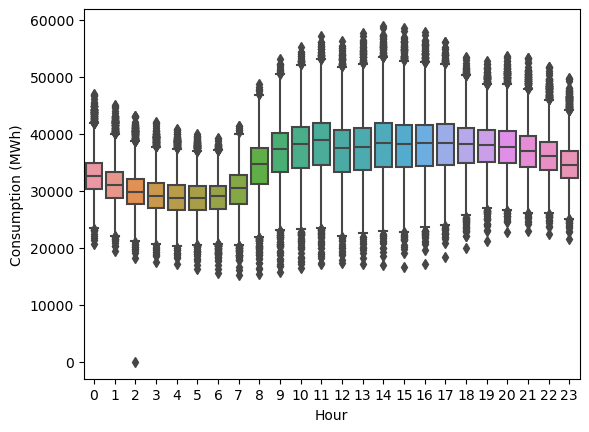

In [405]:
#boxplot to visualize outliers for target variable
sns.boxplot(df,x='Hour',y='Consumption (MWh)')
plt.show()

In [427]:
#getting rid of the obvious outlier 
df = df[df["Consumption (MWh)"] != 0]

In [324]:
#remove outliers with IQR method
Q1 = df['Consumption (MWh)'].quantile(0.25)
Q3 = df['Consumption (MWh)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#define clean version of df with upper and lower bounds
df_cleaned = df[(df['Consumption (MWh)'] >= lower_bound) & (df['Consumption (MWh)'] <= upper_bound)]

#print new data shape
print("Cleaned Data Shape")
df_cleaned.shape

Cleaned Data Shape


(77935, 170)

In [409]:
#check for number of columns with missing values
df.isnull().any().sum()

81

In [500]:
#simple imputing for the missing values based on the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(df.iloc[:,7:])
df.iloc[:,7:] = imputer.transform(df.iloc[:, 7:])
df

,Day,Month,Year,Hour,Weekend,National_holiday,Non_working_day,Adana,Adıyaman,Afyonkarahisar,...,Tekirdağ_pop,Tokat_pop,Trabzon_pop,Tunceli_pop,Uşak_pop,Van_pop,Yalova_pop,Yozgat_pop,Zonguldak_pop,Consumption (MWh)
Index,,,,,,,,,,,,,,,,,,,,,
0,1,1,2016,0,False,True,True,17.6,10.3,10.7,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,26277.24
1,1,1,2016,1,False,True,True,16.0,9.8,9.2,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,24991.82
2,1,1,2016,2,False,True,True,15.0,9.8,8.1,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,23532.61
3,1,1,2016,3,False,True,True,14.6,9.5,7.6,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,22464.78
4,1,1,2016,4,False,True,True,15.0,8.8,7.0,...,969128.0,597994.0,773058.0,82053.0,351194.0,1097762.0,230538.0,413883.0,593718.0,22002.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78378,9,12,2024,19,False,False,False,20.0,12.1,11.1,...,1158621.0,599772.0,810537.0,88871.0,368963.0,1123997.0,279969.0,410875.0,586703.0,43380.10
78379,9,12,2024,20,False,False,False,21.0,12.7,11.8,...,1158621.0,599772.0,810537.0,88871.0,368963.0,1123997.0,279969.0,410875.0,586703.0,42118.38
78380,9,12,2024,21,False,False,False,21.2,14.1,12.4,...,1158621.0,599772.0,810537.0,88871.0,368963.0,1123997.0,279969.0,410875.0,586703.0,41075.61


In [502]:
#check number of null columns again
df.isnull().any().sum()

0

In [415]:
#find top 20 highest correlation coefficent between the variables and consumption 
correlations = df.corr(numeric_only=True)["Consumption (MWh)"].sort_values(ascending=False)
print("Correlation Coefficients")
correlations.head(20)

Correlation Coefficients


Consumption (MWh)     1.000000
Hour                  0.448145
Çanakkale_pop         0.393841
Bilecik_pop           0.385147
Year                  0.384805
Tekirdağ_pop          0.383218
Yalova_pop            0.382304
Karaman_pop           0.381596
Sakarya_pop           0.379510
Konya_pop             0.379205
Kırklareli_pop        0.379025
Aydın_pop             0.378823
Ankara_pop            0.378693
Afyonkarahisar_pop    0.378349
Muğla_pop             0.378063
Bolu_pop              0.377849
Kocaeli_pop           0.377668
Burdur_pop            0.376089
Balıkesir_pop         0.375278
Denizli_pop           0.375140
Name: Consumption (MWh), dtype: float64

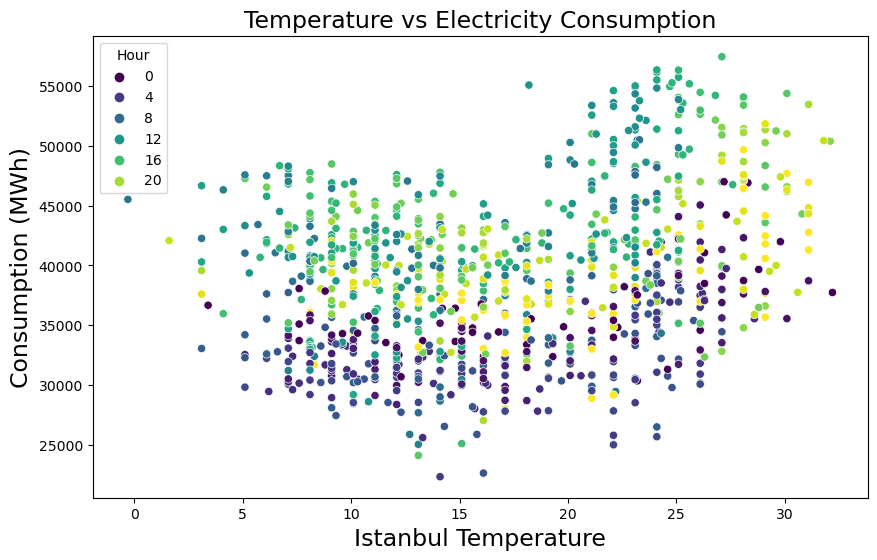

In [417]:
#visualizing relationship between electricity consumption and temperature in Istanbul 
temp=df[df["Year"]==2024]
temp=df.sample(n=1000,random_state=42)
plt.figure(figsize=(10,6))
sns.scatterplot(data=temp, 
                x='İstanbul', 
                y='Consumption (MWh)', 
                hue='Hour', palette='viridis')
plt.xlabel("Istanbul Temperature",fontsize=17)
plt.ylabel("Consumption (MWh)",fontsize=17)
plt.title('Temperature vs Electricity Consumption',fontsize=17)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


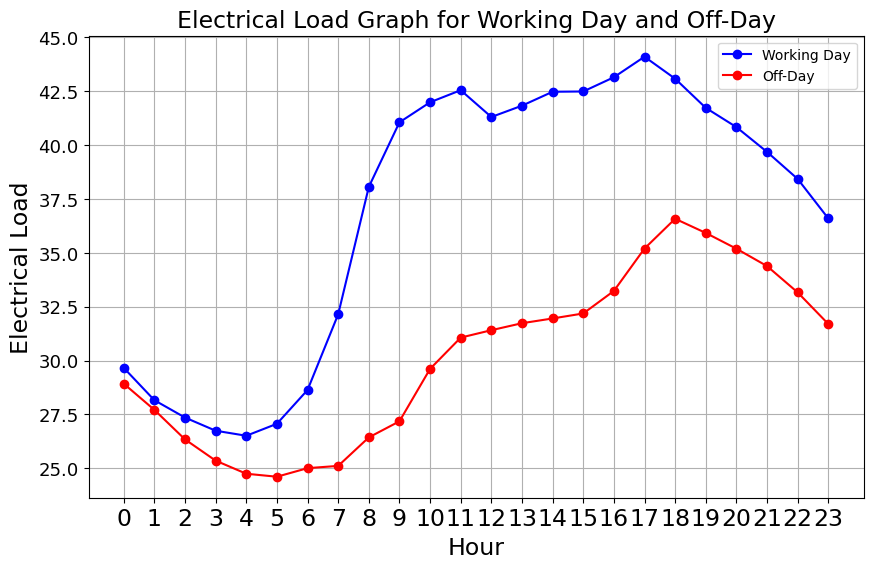

In [433]:
#compare electiricity consumption metrics in average working vs non-working day
plt.figure(figsize=(10, 6))
plt.plot(df['Hour'][70151:70175], df['Consumption (MWh)'][70151:70175]/1000, marker='o', linestyle='-',color='b', label='Working Day', linewidth=1.5,alpha=1)
plt.plot(df['Hour'][70127:70151], df['Consumption (MWh)'][70127:70151]/1000, marker='o', linestyle='-',color='r', label='Off-Day',linewidth=1.5,alpha=1)
plt.xlabel('Hour', fontsize=17)
plt.ylabel('Electrical Load', fontsize=17)
plt.title("Electrical Load Graph for Working Day and Off-Day", fontsize=17)
plt.yticks(fontsize=13)
plt.xticks(df['Hour'][:24], fontsize=17)
plt.grid(True)
plt.legend()
plt.savefig('cons_plot.eps',format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


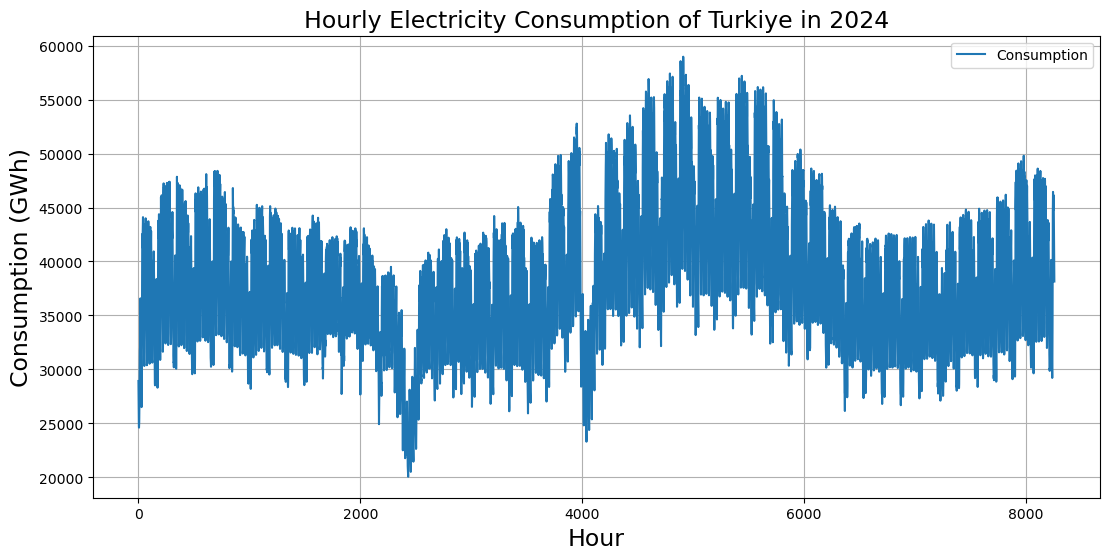

In [391]:
#plot consumption graph of Turkiye for the year of 2024 on hourly basis
temp= df.query("Year == 2024")["Consumption (MWh)"]
plt.figure(figsize=(13,6))
plt.plot(np.array(temp),linestyle='-',label='Consumption',linewidth=1.5,alpha=1)
plt.xlabel("Hour",fontsize=17)
plt.ylabel("Consumption (GWh)",fontsize=17)
plt.title("Hourly Electricity Consumption of Turkiye in 2024",fontsize=17)
plt.grid(True)
plt.legend()
plt.savefig("consumption_trend_yearly",format='eps')
plt.show()

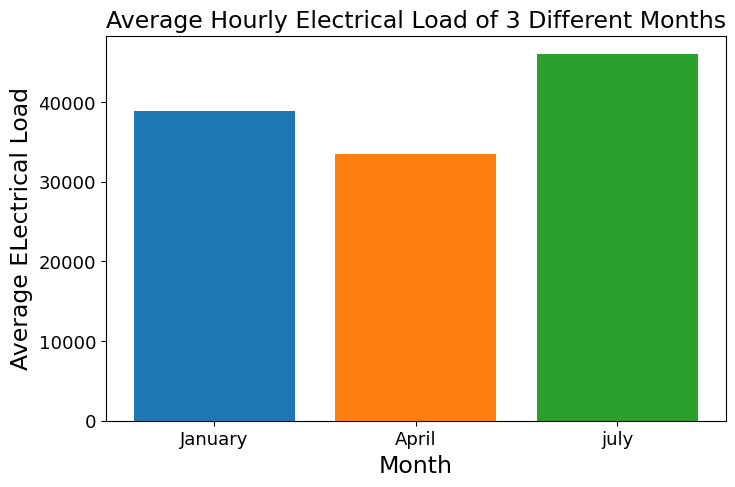

In [158]:
#find average consumption value of 3 different months in 2024
temp = df[df["Year"]==2024].groupby(by="Month")["Consumption (MWh)"].mean()
months = ['January', 'April', 'july']
averages = [temp[1],temp[4],temp[7]]

#plot the results as bar chart
plt.figure(figsize=(8, 5))
plt.bar(months, averages, color=['#1f77b4', '#ff7f0e', '#2ca02c'],linewidth=1.5, alpha=1)
plt.title("Average Hourly Electrical Load of 3 Different Months", fontsize=17)
plt.ylabel('Average ELectrical Load',fontsize=17)
plt.xlabel('Month', fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig("average_values_plot.eps", format='eps', dpi=300)
plt.show()

In [522]:
#code to slice df for medium and long term estimation
#df=df.iloc[:-696,:] #medium-term
df=df.iloc[:-8760,:] #long-term
df = df.sample(n=10000, random_state=42) #sampling

In [4]:
#split dataframe as feature matrix and target variable
X = df.iloc[:,:7].values #for time-based features only
#X = df.iloc[:,:-1].values #for all the features
y = df.iloc[:,-1].values

In [6]:
#split X and y as 80-20 ratio to be used as train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [281]:
#scale data for non-tree based models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)

# Training Models

In [301]:
#write function of evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def cross_validate_metrics(models, X, y, cv=5):
    results = []
    for name, model in models.items():
        print(f"Evaluating {name}...")
        y_pred = cross_val_predict(model, X, y, cv=cv)
        
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mape = mean_absolute_percentage_error(y, y_pred)
        
        results.append({
            "Model": name,
            "R^2": r2,
            "RMSE": rmse,
            "MAPE": mape
        })
    return results

#train models and list the evaluation results of cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),  
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'XGBoost': xgb.XGBRegressor(max_depth=7, learning_rate=0.042, n_estimators=800, reg_lambda=1.0, verbosity=0, 
    random_state=42),
    'LightGBM': lgb.LGBMRegressor(max_depth=5, learning_rate=0.1, n_estimators=100,reg_lambda=1.0, verbose=-1, 
    random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
    'Random Forest': RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_leaf=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42),
}

results = cross_validate_metrics(models, X_train, y_train)

#print results
results_df = pd.DataFrame(results)
print("Evaluation Results \n")
print(results_df.sort_values(by="R^2", ascending=False))

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating Elastic Net...
Evaluating XGBoost...
Evaluating LightGBM...
Evaluating DecisionTreeRegressor...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluation Results 

                   Model       R^2         RMSE       MAPE
4                XGBoost  0.954152  1244.952614   2.647844
8      Gradient Boosting  0.899651  1841.833714   4.100144
5               LightGBM  0.898447  1852.849843   4.121287
7          Random Forest  0.891004  1919.549293   4.311453
6  DecisionTreeRegressor  0.714315  3107.694081   7.106304
1       Ridge Regression  0.459152  4275.948433  10.044564
2       Lasso Regression  0.459152  4275.948919  10.044574
0      Linear Regression  0.459152  4275.949252  10.044554
3            Elastic Net  0.451107  4307.630149  10.136907


# Optimizing Parameters

In [447]:
#create custom MAPE scorer to be used in hyperparameter optimization
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [449]:
#apply grid search for Gradient Boosting to optimize parameters

#train the unoptimized model to compare later
unoptimized_model = GradientBoostingRegressor(random_state=42)
unoptimized_model.fit(X_train, y_train)

#predictions and evaluation for the unoptimized model
y_pred_unoptimized = unoptimized_model.predict(X_test)
r2_unoptimized = r2_score(y_test, y_pred_unoptimized)
rmse_unoptimized = np.sqrt(mean_squared_error(y_test, y_pred_unoptimized))
mape_unoptimized = mean_absolute_percentage_error(y_test, y_pred_unoptimized)

#define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'subsample': [0.8, 0.9],
}

#apply grid search with given parameters
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring=mape_scorer,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

#retrieve best parameters and model
best_params = grid_search.best_params_
optimized_model = grid_search.best_estimator_

#predictions and evaluation for the optimized model
y_pred_optimized = optimized_model.predict(X_test)
r2_optimized = r2_score(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)

#compare unoptimized and optimized model
results = pd.DataFrame({
    "Model": ["Unoptimized", "Optimized"],
    "R²": [r2_unoptimized, r2_optimized],
    "RMSE": [rmse_unoptimized, rmse_optimized],
    "MAPE": [mape_unoptimized, mape_optimized]
})

#print results
print("GradientBoosting")
print(results)
print("Optimal Parameters from Grid Search:", best_params)

GradientBoosting
         Model        R²         RMSE      MAPE
0  Unoptimized  0.854396  2267.282842  0.050810
1    Optimized  0.921328  1666.590163  0.035223
Optimal Parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}


In [200]:
#apply random search for Gradient Boosting to optimize parameters


#define hyperparameter distribution ranges
param_distributions = {
    'n_estimators': np.arange(100, 501, 50),  
    'learning_rate': np.linspace(0.01, 0.15, 10), 
    'max_depth': np.arange(3, 9),
    'subsample': np.linspace(0.7, 0.9, 5)  
}

#apply random search with given parameters
random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=50, 
    scoring=mape_scorer,
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

#retrieve best parameters and model
best_random_params = random_search.best_params_
random_best_model = random_search.best_estimator_

#predictions and evaluation for the optimized model
y_pred_random = random_best_model.predict(X_test)
r2_random = r2_score(y_test, y_pred_random)
rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))
mape_random = mean_absolute_percentage_error(y_test, y_pred_random)

#compare unoptimized and optimized model
results = pd.DataFrame({
    "Model": ["Unoptimized", "Optimized"],
    "R²": [r2_unoptimized, r2_optimized],
    "RMSE": [rmse_unoptimized, rmse_optimized],
    "MAPE": [mape_unoptimized, mape_optimized]
})

#print results
print("GradientBoosting")
print(results)
print("Optimal Parameters from Randomized Search:", best_params)

Optimal Parameters from Random Search: {'subsample': 1.0, 'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.11888888888888886}
R²: 0.9246, RMSE: 1631.4562, MAPE: 0.0345


In [451]:
#apply grid search for LightGBM to optimize parameters

#train the unoptimized model to compare later
unoptimized_model = LGBMRegressor(random_state=42)
unoptimized_model.fit(X_train, y_train)

#predictions and evaluation for the unoptimized model
y_pred_unoptimized = unoptimized_model.predict(X_test)
r2_unoptimized = r2_score(y_test, y_pred_unoptimized)
rmse_unoptimized = np.sqrt(mean_squared_error(y_test, y_pred_unoptimized))
mape_unoptimized = mean_absolute_percentage_error(y_test, y_pred_unoptimized)

#define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],  
    'subsample': [0.8, 0.9],
    'num_leaves': [31, 50], 
}

#apply grid search with given parameters
grid_search = GridSearchCV(
    LGBMRegressor(random_state=42,verbosity=-1),
    param_grid,
    cv=5,
    scoring=mape_scorer,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

#retrieve best parameters and model
best_params = grid_search.best_params_
optimized_model = grid_search.best_estimator_

#predictions and evaluation for the optimized model
y_pred_optimized = optimized_model.predict(X_test)
r2_optimized = r2_score(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)

#compare unoptimized and optimized model
results = pd.DataFrame({
    "Model": ["Unoptimized", "Optimized"],
    "R²": [r2_unoptimized, r2_optimized],
    "RMSE": [rmse_unoptimized, rmse_optimized],
    "MAPE": [mape_unoptimized, mape_optimized]
})

#print results
print("LightGBM")
print(results)
print("Optimal Parameters from Grid Search:", best_params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 7
[LightGBM] [Info] Start training from score 34880.258355
LightGBM
         Model        R²         RMSE      MAPE
0  Unoptimized  0.904202  1839.071049  0.040674
1    Optimized  0.918025  1701.218301  0.036511
Optimal Parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}


In [128]:
#apply random search for LightGBM to optimize parameters

#define hyperparameter distribution ranges
param_distributions = {
    'n_estimators': np.arange(50, 301, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': [2, 3, 4, 5, 6, 7, 8], 
    'subsample': np.linspace(0.7, 0.9, 5),
    'num_leaves': np.arange(20, 100, 10), 
}

#apply random search with given parameters
random_search = RandomizedSearchCV(
    LGBMRegressor(random_state=42,verbosity=-1),
    param_distributions=param_distributions,
    n_iter=50,
    scoring=mape_scorer,
    cv=5,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

#retrieve best parameters and model
best_params = random_search.best_params_
optimized_model = random_search.best_estimator_

#predictions and evaluation for the optimized model
y_pred_optimized = optimized_model.predict(X_test)
r2_optimized = r2_score(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)

#compare unoptimized and optimized model
results = pd.DataFrame({
    "Model": ["Unoptimized", "Optimized"],
    "R²": [r2_unoptimized, r2_optimized],
    "RMSE": [rmse_unoptimized, rmse_optimized],
    "MAPE": [mape_unoptimized, mape_optimized]
})

#print results
print("LightGBM")
print(results)
print("Optimal Parameters from Randomized Search:", best_params)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 62706, number of used features: 7
[LightGBM] [Info] Start training from score 34901.067375
LightGBM (Randomized Search)
         Model        R²         RMSE      MAPE
0  Unoptimized  0.920224  1691.698358  0.037674
1    Optimized  0.927026  1617.965655  0.035617
Optimal Parameters from Randomized Search: {'subsample': 0.7, 'num_leaves': 90, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.2}


In [ ]:
#apply grid search for XGBoost to optimize parameters

#train the unoptimized model to compare later
unoptimized_model = xgb.XGBRegressor(random_state=42)
unoptimized_model.fit(X_train, y_train)

#predictions and evaluation for the unoptimized model
y_pred_unoptimized = unoptimized_model.predict(X_test)
r2_unoptimized = r2_score(y_test, y_pred_unoptimized)
rmse_unoptimized = np.sqrt(mean_squared_error(y_test, y_pred_unoptimized))
mape_unoptimized = mean_absolute_percentage_error(y_test, y_pred_unoptimized)

#define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1],
}

#apply grid search with given parameters
grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42,verbosity=0),
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

#retrieve best parameters and model
best_params_grid = grid_search.best_params_
optimized_model_grid = grid_search.best_estimator_

#predictions and evaluation for the optimized model
y_pred_optimized_grid = optimized_model_grid.predict(X_test)
r2_grid = r2_score(y_test, y_pred_optimized_grid)
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_optimized_grid))
mape_grid = mean_absolute_percentage_error(y_test, y_pred_optimized_grid)

#compare unoptimized and optimized model
results = pd.DataFrame({
    "Model": ["Unoptimized", "Optimized"],
    "R²": [r2_unoptimized, r2_optimized],
    "RMSE": [rmse_unoptimized, rmse_optimized],
    "MAPE": [mape_unoptimized, mape_optimized]
})

#print results
print("XGBoost")
print(results)
print("Optimal Parameters from Grid Search:", best_params)

In [438]:
#apply random search for XGBoost to optimize parameters

#define hyperparameter distribution ranges
param_distributions = {
    'n_estimators': np.arange(50, 1001, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 11, 1),
    'subsample': np.linspace(0.5, 1.0, 5),
    'colsample_bytree': np.linspace(0.5, 1.0, 5),
    'gamma': np.arange(0, 6, 1),
    'reg_alpha': np.linspace(0, 1, 5),
    'reg_lambda': np.linspace(0, 1, 5),
}

#apply random search with given parameters
random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42,verbosity=0),
    param_distributions=param_distributions,
    n_iter=50,
    scoring=mape_scorer,  
    cv=5,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

#retrieve best parameters and model
best_params_random = random_search.best_params_
optimized_model_random = random_search.best_estimator_

#predictions and evaluation for the optimized model
y_pred_optimized_random = optimized_model_random.predict(X_test)
r2_random = r2_score(y_test, y_pred_optimized_random)
rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_optimized_random))
mape_random = mean_absolute_percentage_error(y_test, y_pred_optimized_random)

#compare unoptimized and optimized model
results = pd.DataFrame({
    "Model": ["Unoptimized", "Optimized"],
    "R²": [r2_unoptimized, r2_optimized],
    "RMSE": [rmse_unoptimized, rmse_optimized],
    "MAPE": [mape_unoptimized, mape_optimized]
})

#print results"
print("XGBoost")
print(results)
print("Optimal Parameters from Randomized Search:", best_params)

XGBoost (Randomized Search)
Best Parameters: {'subsample': 0.875, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.042222222222222223, 'gamma': 1, 'colsample_bytree': 0.75}
R²: 0.9238, RMSE: 1596.3574, MAPE: 0.0340


# Real-world Application of Models

In [10]:
#reading csv file with feature matrix of December 10, 2024 for real-world application of models
dec_10_data = pd.read_csv('./data/10_dec_data.csv', index_col=0)
dec_10_data

,Day,Month,Year,Hour,Weekend,National_holiday,Non_working_day
0,10,12,2024,0,False,False,False
1,10,12,2024,1,False,False,False
2,10,12,2024,2,False,False,False
3,10,12,2024,3,False,False,False
4,10,12,2024,4,False,False,False
5,10,12,2024,5,False,False,False
6,10,12,2024,6,False,False,False
7,10,12,2024,7,False,False,False
8,10,12,2024,8,False,False,False
9,10,12,2024,9,False,False,False


In [12]:
#actual load for 10 December, 2024
actual_values = np.array([35921.33, 34121.36, 33085.15, 32388.38, 32036.37, 32434.27, 33812.06, 36761.83, 42248.48, 44320.46, 44625.19, 44739.65, 42910.77, 43494.90, 43499.12, 44181.94, 44866.27, 46087.89, 45155.86, 43849.07, 42837.26, 41802.95, 40363.17, 37993.86]) 

In [14]:
#define Gradient Boosting model trained with whole dataset

#optimal parameters found with search methods
params = {
    'n_estimators': 250,          
    'learning_rate': 0.0944,  
    'max_depth': 6,               
    'subsample': 0.85,            
    'loss': 'squared_error',  
    "random_state": 42
}

#train the model with given parameters
gb_model = GradientBoostingRegressor(n_estimators=params['n_estimators'], 
                                     learning_rate=params['learning_rate'],
                                     max_depth=params['max_depth'],
                                     subsample=params['subsample'],
                                     loss=params['loss'],
                                    )
gb_model.fit(X_train, y_train)

#make predictions
y_pred = gb_model.predict(X_test)

#evaluate the performance of model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

#predict electrical load for 10 December
predictions = gb_model.predict(dec_10_data)
print("Prediction results")
predictions

Root Mean Squared Error (RMSE): 1425.3782770798286
Prediction results


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


array([35238.3450014 , 33153.10561504, 31685.47653544, 31298.46918961,
       31130.99906619, 31379.44294602, 32706.07047913, 35549.33352765,
       41223.55294014, 44220.85290729, 45060.63146606, 45584.30642804,
       43975.65291572, 44376.70002551, 45030.64711841, 44963.24959995,
       45361.55447737, 46465.9628544 , 45803.7504833 , 44460.39941251,
       43800.4463174 , 42583.95384012, 40992.51680625, 38939.75757733])

In [17]:
#define Gradient Boosting model trained with 10.000 records

#optimal parameters found with search methods
params = {
    'n_estimators': 450,      
    'learning_rate': 0.1188,  
    'max_depth': 6,               
    'subsample': 1,            
    'loss': 'squared_error',
    'random_state':42
}

#train the model with given parameters
gb_model = GradientBoostingRegressor(n_estimators=params['n_estimators'], 
                                     learning_rate=params['learning_rate'],
                                     max_depth=params['max_depth'],
                                     subsample=params['subsample'],
                                     loss=params['loss'],
                                    )
gb_model.fit(X_train, y_train)

#make predictions
y_pred = gb_model.predict(X_test)

#evaluate the performance of model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

#predict electrical load for 10 December
predictions = gb_model.predict(dec_10_data)
print("Prediction results")
predictions

Root Mean Squared Error (RMSE): 1622.8643681373276


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


array([33628.55492478, 33966.03190061, 32556.44435262, 31742.31717166,
       31471.01891247, 31702.40856133, 32984.29246471, 36329.74047496,
       43393.31434952, 45745.91561815, 44839.39257785, 45715.84054785,
       42803.60660401, 44345.0613072 , 45291.88361496, 45395.04201998,
       46007.41313681, 47433.68786587, 46948.11177928, 45547.77207363,
       44188.48845979, 43365.52476268, 41988.85640351, 39604.31184306])

In [546]:
#define LightGBM model trained with whole dataset

#create the dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

#optimal parameters found with search methods
optimized_params = {
    'objective': 'regression',     
    'metric': 'rmse',              
    'boosting_type': 'gbdt',       
    'max_depth': 4,               
    'learning_rate': 0.1578,  
    'n_estimators': 300,           
    'subsample': 0.85,             
    'num_leaves': 70,              
    'reg_lambda': 0.5,             
    'reg_alpha': 0.0,              
    'feature_fraction': 0.9,
    'random_state':42,
    'verbosity':-1
}

#train the model with given parameters
num_round = optimized_params['n_estimators'] 
lgb_model = lgb.train(optimized_params, train_data, num_round, valid_sets=[test_data])

#make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

#evaluate the performance of model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

#predict electrical load for 10 December
predictions = lgb_model.predict(dec_10_data)
print("Prediction results")
predictions

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Root Mean Squared Error (RMSE): 1717.0624495244263
Prediction results


array([35235.04060824, 33492.74575413, 31831.42510309, 31054.33904862,
       31147.23234911, 31300.01388035, 32543.42145666, 34033.34689081,
       39578.30108152, 42061.56191316, 42614.65581251, 42967.08445876,
       41716.05574646, 42089.55931061, 43040.30203474, 43005.73712876,
       43026.61356109, 43830.08520613, 43472.98778284, 42788.52117564,
       41466.4078    , 40354.75940554, 38753.32427089, 36801.0492839 ])

In [550]:
#define LightGBM model trained with 10.000 records

#create the dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

#optimal parameters found with search methods
optimized_params = {
    'objective': 'regression',     
    'metric': 'rmse',              
    'boosting_type': 'gbdt',       
    'max_depth': 8,               
    'learning_rate': 0.1578,  
    'n_estimators': 300,           
    'subsample': 0.85,             
    'num_leaves': 50,              
    'reg_lambda': 0.5,             
    'reg_alpha': 0.0,              
    'feature_fraction': 0.9,
    'random_state':42,
    'verbosity':-1
}

#train the model with given parameters
num_round = optimized_params['n_estimators']  
lgb_model = lgb.train(optimized_params, train_data, num_round, valid_sets=[test_data])

#make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

#evaluate the performance of model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

#predict electrical load for 10 December
predictions = lgb_model.predict(dec_10_data)
print("Prediction results")
predictions

/opt/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Root Mean Squared Error (RMSE): 1602.684244878885
Prediction results


array([34736.4271741 , 32618.23098518, 30827.50665297, 30191.91832834,
       30314.62285776, 30664.41641434, 32628.73844499, 34155.68011342,
       39093.57802441, 41412.90375143, 41903.7499442 , 42459.71929158,
       41071.93915744, 40933.81253196, 42034.81793379, 42009.35802453,
       41861.32417602, 42861.58272189, 42502.3856818 , 41182.67522597,
       40166.90228273, 39537.88049933, 38272.5901766 , 36687.59571843])

In [554]:
#define XGBoost model trained with whole dataset

#create DMatrix with train and test data
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

#optimal parameters found with search methods
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',            
    'max_depth': 7,                   
    'learning_rate': 0.1066,  
    'n_estimators': 850,              
    'reg_lambda': 0.5,                
    'reg_alpha': 0.0,                 
    'subsample': 0.875,               
    'min_child_weight': 1,            
    'gamma': 1,                       
    'colsample_bytree': 0.875,
    'random_state':42
}

#train the model with given parameters
num_round = 850
xgb_model = xgb.train(params, train_data, num_round, evals=[(test_data, 'test')],verbose_eval=0)

#make predictions
y_pred = xgb_model.predict(test_data)

#evaluate the performance of model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

#predict electrical load for 10 December
dec_10_data_dmatrix = xgb.DMatrix(dec_10_data) 
predictions = xgb_model.predict(dec_10_data_dmatrix)
print("Prediction results")
predictions

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 1592.0043521079367
Prediction results


array([34164.03 , 31943.105, 30457.514, 30294.021, 30084.709, 30466.656,
       32899.934, 34038.79 , 39389.363, 42315.777, 41787.137, 41785.715,
       39915.098, 40443.156, 41643.01 , 42230.207, 41410.66 , 42537.17 ,
       42210.645, 40027.797, 39501.797, 38976.39 , 37741.48 , 36238.836],
      dtype=float32)

In [464]:
#define XGBoost model trained with 10.000 records

#create DMatrix with train and test data
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

#optimal parameters found with search methods
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse',           
    'max_depth': 7,                  
    'learning_rate': 0.042, 
    'n_estimators': 800,             
    'reg_lambda': 1.0,               
    'reg_alpha': 0.0,                
    'subsample': 0.875,              
    'min_child_weight': 1,           
    'gamma': 1,                      
    'colsample_bytree': 0.75,
    'random_state':42
}

#train the model with given parameters
num_round = 850  
xgb_model = xgb.train(params, train_data, num_round, evals=[(test_data, 'test')],verbose_eval=0)

#make predictions
y_pred = xgb_model.predict(test_data)

#evaluate the performance of model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

#predict electrical load for 10 December
dec_10_data_dmatrix = xgb.DMatrix(dec_10_data)
predictions = xgb_model.predict(dec_10_data_dmatrix)
print("Prediction results")
predictions

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 1643.7073408234344
Prediction results


array([35263.504, 34501.77 , 33215.203, 32501.068, 32543.201, 32569.877,
       33585.66 , 36427.566, 43111.656, 45920.598, 46501.207, 47188.152,
       43898.36 , 45096.082, 45672.76 , 45864.562, 46062.543, 47525.277,
       46610.164, 45083.867, 44743.902, 43341.758, 42012.184, 40031.29 ],
      dtype=float32)

# Evaluating Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


RMSE: 1119.5090241498829
R^2: 0.9464265008667186
MAPE: 2.718096403638763%


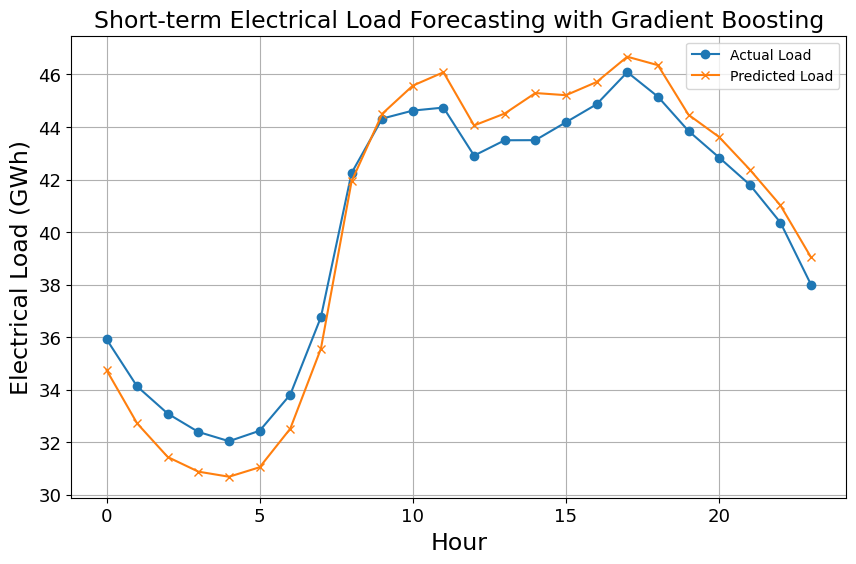

In [32]:
#calculating RMSE, R^2 and MAPE values of the prediction
predicted_values = prediction
rmse = np.sqrt(np.mean((actual_values - predicted_values) ** 2))
r2 = r2_score(actual_values, predicted_values)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

#print results 
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"MAPE: {mape}%")

#draw line plot of the prediction and actual data in GWh
actual_values = actual_values /1000
predicted_values= predicted_values/1000
plt.plot(actual_values, label="Actual Load", marker='o', linewidth=1.5,alpha=1)
plt.plot(predicted_values, label="Predicted Load", marker='x', linewidth=1.5,alpha=1)
plt.title("Short-term Electrical Load Forecasting with Gradient Boosting",fontsize=17)
plt.xlabel("Hour",fontsize=17)
plt.ylabel("Electrical Load (GWh)",fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.grid(True)
plt.savefig('st_gb_001_test.eps',format='eps')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Empirical Coverage: 70.83%
Mean Interval Width: 2984.36


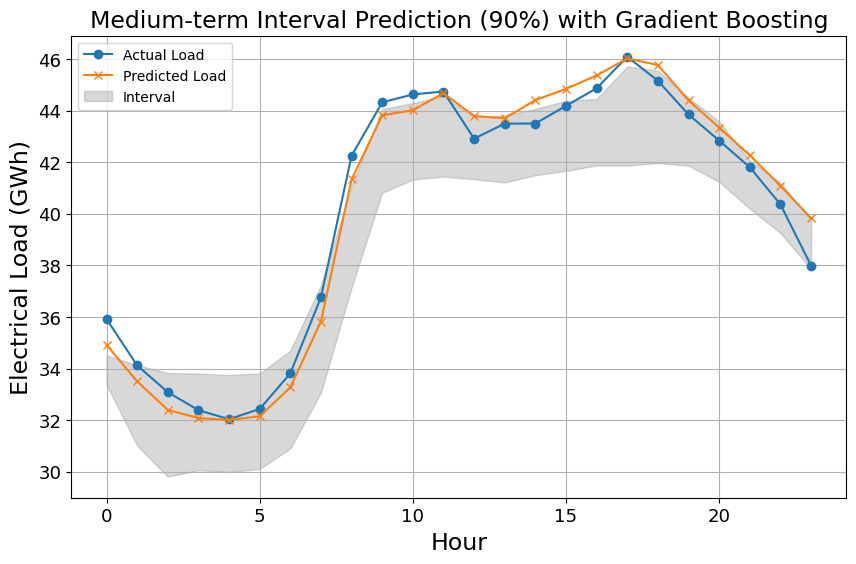

In [478]:
#parameters for Gradient Boosting percentile model
params = {
    'n_estimators': 250,
    'learning_rate': 0.0944,
    'max_depth': 6,
    'subsample': 0.85,
    'random_state': 42
}

#train lower bound of the model
lower_model = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.05,
    **params
)
lower_model.fit(X_train, y_train)

# Train upper bound of the model
upper_model = GradientBoostingRegressor(
    loss='quantile',
    alpha=0.95,
    **params
)
upper_model.fit(X_train, y_train)

#train the main model 
main_model = GradientBoostingRegressor(
    loss='squared_error',
    **params
)
main_model.fit(X_train, y_train)

#prediction results
y_lower = lower_model.predict(dec_10_data)
y_upper = upper_model.predict(dec_10_data)
y_pred = main_model.predict(dec_10_data)

#calculate coverage and interval width
coverage = np.mean((actual_values >= y_lower) & (actual_values <= y_upper)) * 100
interval_width = np.mean(y_upper - y_lower)

print(f"Empirical Coverage: {coverage:.2f}%")
print(f"Mean Interval Width: {interval_width:.2f}")

#plot the results with actual data in GWh
plt.figure(figsize=(10, 6))
plt.plot(actual_values/1000, label='Actual Load', marker='o',linewidth=1.5,alpha=1)
plt.plot(y_pred/1000, label='Predicted Load', marker='x',linewidth=1.5,alpha=1)
plt.fill_between(range(len(actual_values)), y_lower/1000, y_upper/1000, color='gray', alpha=0.3, label='Interval')
plt.title("Medium-term Interval Prediction (90%) with Gradient Boosting",fontsize=17)
plt.xlabel("Hour",fontsize=17)
plt.ylabel("Electrical Load (GWh)",fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.grid(True)
plt.savefig("interval_est_gb_st.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Empirical Coverage: 70.83%
Mean Interval Width: 2701.52


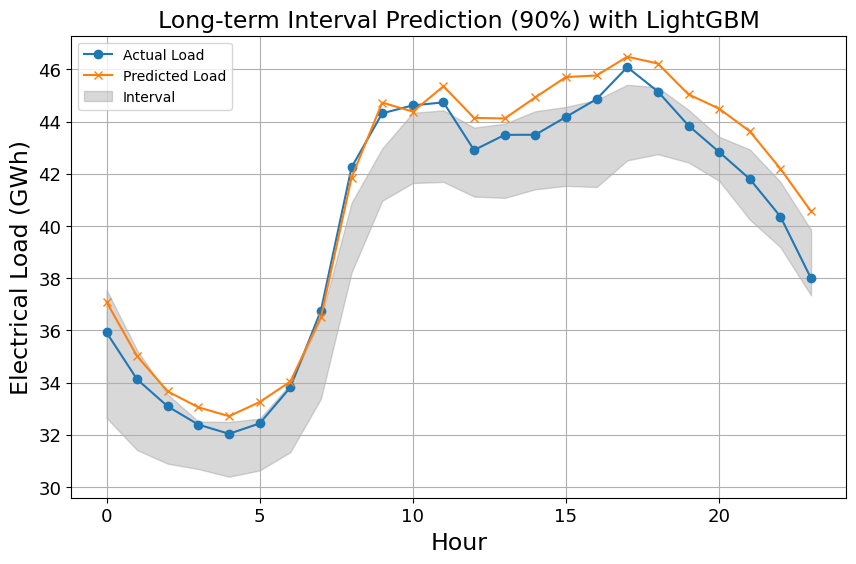

In [480]:
#parameters for LightGBM percentile model
params = {
    'subsample': 0.85,
    'num_leaves': 50,
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1578,
    'random_state': 42,
    'verbosity':-1
}

#train lower bound of the model
lower_model = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.05,
    **params
)
lower_model.fit(X_train, y_train)

#train upper bound of the model
upper_model = lgb.LGBMRegressor(
    objective='quantile',
    alpha=0.95,
    **params
)
upper_model.fit(X_train, y_train)

#train the main model 
main_model = lgb.LGBMRegressor(
    objective='regression',
    **params
)
main_model.fit(X_train, y_train)

#prediction results
y_lower = lower_model.predict(dec_10_data)
y_upper = upper_model.predict(dec_10_data)
y_pred = main_model.predict(dec_10_data)

#calculate coverage and interval width
coverage = np.mean((actual_values >= y_lower) & (actual_values <= y_upper)) * 100
interval_width = np.mean(y_upper - y_lower)

print(f"Empirical Coverage: {coverage:.2f}%")
print(f"Mean Interval Width: {interval_width:.2f}")

#plot the results with actual data in GWh
plt.figure(figsize=(10, 6))
plt.plot(actual_values/1000, label='Actual Load', marker='o',linewidth=1.5,alpha=1)
plt.plot(y_pred/1000, label='Predicted Load', marker='x',linewidth=1.5,alpha=1)
plt.fill_between(range(len(actual_values)), y_lower/1000, y_upper/1000, color='gray', alpha=0.3, label='Interval')
plt.title("Long-term Interval Prediction (90%) with LightGBM",fontsize=17)
plt.xlabel("Hour",fontsize=17)
plt.ylabel("Electrical Load (GWh)",fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.grid(True)
plt.savefig("interval_est_lgb_lt-test.eps")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.10 | Empirical Coverage = 0.000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.20 | Empirical Coverage = 0.125


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.30 | Empirical Coverage = 0.250


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.40 | Empirical Coverage = 0.125


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.50 | Empirical Coverage = 0.292


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.60 | Empirical Coverage = 0.583


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.70 | Empirical Coverage = 0.500


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Nominal α = 0.80 | Empirical Coverage = 0.833


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Nominal α = 0.90 | Empirical Coverage = 0.917


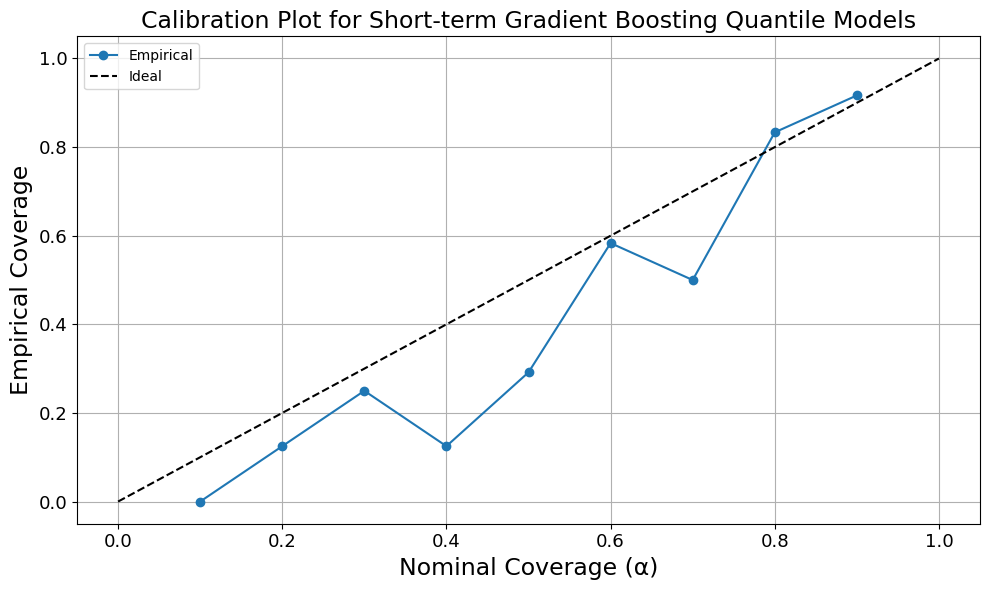

In [36]:
#parameters of Gradient Boosting to calculate empirical coverages for different alpha values
params = {
    'n_estimators': 250,
    'learning_rate': 0.0944,
    'max_depth': 6,
    'subsample': 0.85,
    'random_state': 42
}

#desired alpha values to evaluate with 0.1 frequency
alphas = np.arange(0.1, 1.0, 0.1)
empirical_coverages = []

#loop through each alpha values and make predictions
for alpha in alphas:
    lower_alpha = (1 - alpha) / 2
    upper_alpha = 1 - lower_alpha

    lower_model = GradientBoostingRegressor(loss='quantile', alpha=lower_alpha, **params)
    lower_model.fit(X_train, y_train)

    upper_model = GradientBoostingRegressor(loss='quantile', alpha=upper_alpha, **params)
    upper_model.fit(X_train, y_train)

    y_lower = lower_model.predict(dec_10_data)
    y_upper = upper_model.predict(dec_10_data)

    coverage = np.mean((actual_values >= y_lower) & (actual_values <= y_upper))
    empirical_coverages.append(coverage)

    print(f"Nominal α = {alpha:.2f} | Empirical Coverage = {coverage:.3f}")

#plot the calibration curve with nominal and empirical coverages
plt.figure(figsize=(10, 6))
plt.plot(alphas, empirical_coverages, marker='o', label='Empirical',linewidth=1.5,alpha=1)
plt.plot([0, 1], [0, 1], 'k--', label='Ideal',linewidth=1.5,alpha=1)
plt.xlabel('Nominal Coverage (α)', fontsize=17)
plt.ylabel('Empirical Coverage', fontsize=17)
plt.title('Calibration Plot for Short-term Gradient Boosting Quantile Models', fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cal_plot_gb_st.eps")
plt.show()

Nominal α = 0.10 | Empirical Coverage = 0.000
Nominal α = 0.20 | Empirical Coverage = 0.000
Nominal α = 0.30 | Empirical Coverage = 0.042
Nominal α = 0.40 | Empirical Coverage = 0.000
Nominal α = 0.50 | Empirical Coverage = 0.000
Nominal α = 0.60 | Empirical Coverage = 0.000
Nominal α = 0.70 | Empirical Coverage = 0.000
Nominal α = 0.80 | Empirical Coverage = 0.000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Nominal α = 0.90 | Empirical Coverage = 0.083


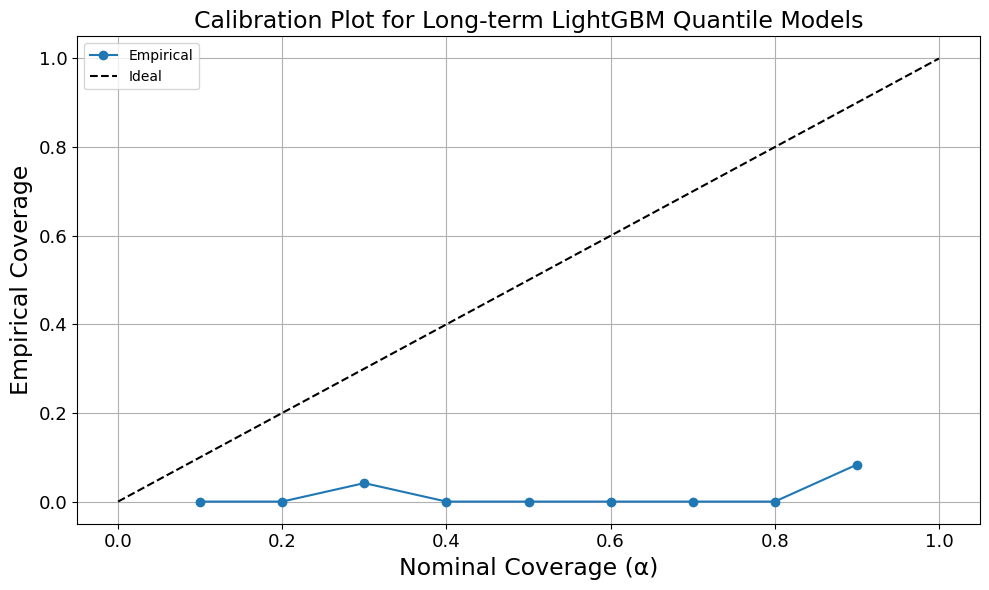

In [528]:
#parameters of LightGBM to calculate empirical coverages for different alpha values
params = {
    "subsample": 0.85,
    "num_leaves": 50,
    "n_estimators": 300,
    "max_depth": 8,
    "learning_rate": 0.1578,
    "random_state": 42,
    'verbosity': -1
}

#desired alpha values to evaluate with 0.1 frequency
alphas = np.arange(0.1, 1.0, 0.1)
empirical_coverages = []

#loop through each alpha values and make predictions
for alpha in alphas:
    lower_alpha = (1 - alpha) / 2
    upper_alpha = 1 - lower_alpha

    lower_model = lgb.LGBMRegressor(objective='quantile', alpha=lower_alpha, **params)
    lower_model.fit(X_train, y_train)

    upper_model = lgb.LGBMRegressor(objective='quantile', alpha=upper_alpha, **params)
    upper_model.fit(X_train, y_train)

    y_lower = lower_model.predict(dec_10_data)
    y_upper = upper_model.predict(dec_10_data)

    coverage = np.mean((actual_values >= y_lower) & (actual_values <= y_upper))
    empirical_coverages.append(coverage)

    print(f"Nominal α = {alpha:.2f} | Empirical Coverage = {coverage:.3f}")

#plot the calibration curve with nominal and empirical coverages
plt.figure(figsize=(10, 6))
plt.plot(alphas, empirical_coverages, marker='o', label='Empirical', linewidth=1.5, alpha=1)
plt.plot([0, 1], [0, 1], 'k--', label='Ideal', linewidth=1.5, alpha=1)
plt.xlabel('Nominal Coverage (α)', fontsize=17)
plt.ylabel('Empirical Coverage', fontsize=17)
plt.title('Calibration Plot for Long-term LightGBM Quantile Models', fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cal_plot_lgb_lt.eps")
plt.show()

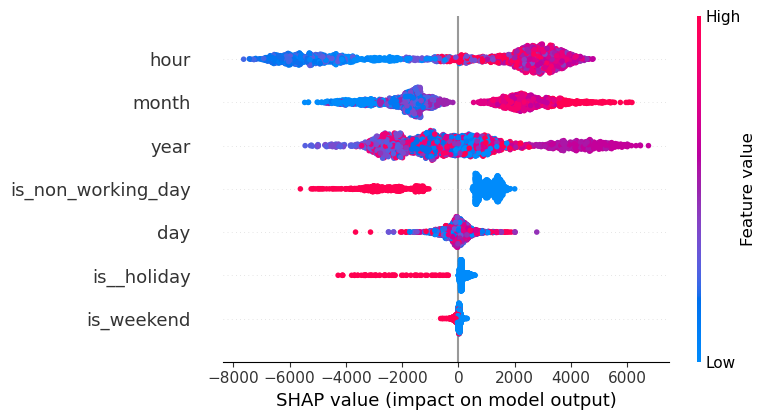

In [486]:
#choosing explainer and calculates values with X_test
explainer = shap.Explainer(gb_model) 
shap_values = explainer(X_test)  

#plot and save results
shap.summary_plot(shap_values, X_test, feature_names = np.array(["day",	"year",	"month", "hour", "is_weekend", "is__holiday", "is_non_working_day"]),show=False)
plt.show()
plt.close()  

In [22]:
#feature names to be plotted on graph
feature_names = np.array(["day", "month", "year", "hour", "is_weekend", "is__holiday", "is_non_working_day"])

#define LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    mode='regression'
)

#explain a record in dataset
exp = explainer.explain_instance(
    data_row=X_test[100],
    predict_fn=gb_model.predict)  

#show and save the graph 
exp.show_in_notebook()